# First mount Google Drive, so you have access to the Car notebook

In [1]:
from google.colab import drive
drive.mount("mnt")

%cd "mnt/My Drive/Colab Notebooks/RPI/CSCI4965 Spring 2022"

Mounted at mnt
/content/mnt/My Drive/Colab Notebooks/RPI/CSCI4965 Spring 2022


# Install ipynb package

In [2]:
!pip install import-ipynb
import import_ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=58eaebb59bfaa78606f7e7f01c78bc5d58eea849d618b1ab218b834b3b57c447
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


# Set up Car world (with state feedack)

In [35]:
import os
import sys

from Car import World
from Car import square_hall_right

# hallway dimensions
hall_width = 2
hall_length = 30

# car starting position and velocity
car_dist_s = 1 # distance to left wall
car_dist_f = 28 # distance to front wall
car_heading = 0.1 # relative to walls
car_V = 2.4

# constant car throttle
throttle = 16

# car dynamics noise
init_pos_noise = 0
init_heading_noise = 0
front_pos_noise = 0

episode_length = 100
time_step = 0.1

# set this to false if you'd like to use lidar
state_feedback = True

# lidar parameters
lidar_field_of_view = 115
lidar_num_rays = 21

# various lidar settings
lidar_noise = 0
missing_lidar_rays = 0
lidar_missing_in_turn_only = False

# set up a square hallway with right turns
(hallWidths, hallLengths, turns) = square_hall_right(hall_width, hall_length)

# create the environment
w = World(hallWidths, hallLengths, turns,\
          car_dist_s, car_dist_f, car_heading, car_V,\
          episode_length, time_step, lidar_field_of_view,\
          lidar_num_rays, lidar_noise, missing_lidar_rays,\
          lidar_missing_in_turn_only, state_feedback=state_feedback)

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Plot Lidar

This is just an example illustrating how to plot LiDAR in case you need to

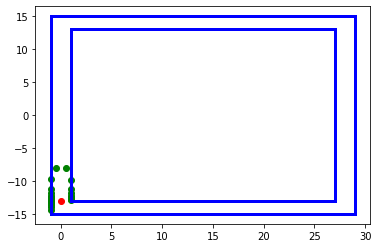

In [ ]:
w.plot_lidar()

# PID Controller

In [4]:
def pid_control(error, int_error, d_error):
    u = -18*error + 0.2 * int_error + 4*d_error
    return u

# Control Loop

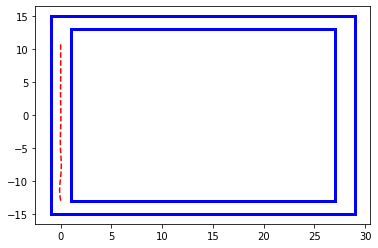

In [23]:
''' observation is an array of 5 elements:
[distance to left wall,
distance to right wall,
distance to front wall,
distance to turn,
heading w.r.t hallway]
'''

# initial position noise parameters
side_pos_noise = 0
heading_noise = 0
front_pos_noise = 0

# reset the environment
observation = w.reset(pos_noise=side_pos_noise, heading_noise=heading_noise, front_pos_noise=front_pos_noise)

# your code goes here and in the loop below
pos_reference = 1
placeholder_err = 0
placeholder_int_err = 0 
placeholder_d_err = 0 

delta = pid_control(placeholder_err, placeholder_int_err, placeholder_d_err)

for e in range(episode_length):

    observation, reward, done, info = w.step(delta, throttle)

    # Calculate Errors
    placeholder_err = pos_reference - observation[0] 
    if e != 0:
        placeholder_int_err = ((placeholder_err ** 2)/2 - (previous_error ** 2)/2 )/ time_step
        placeholder_d_err = -(placeholder_err - previous_error) / time_step

    delta = pid_control(placeholder_err, placeholder_int_err, placeholder_d_err)

    previous_error = placeholder_err

    if done:        
        if e < episode_length - 1:
          print('Unsafe!')
          break

w.plot_trajectory()


# Set up Car world (with lidar feedback)

This code is reusing variables from above, so make sure you run those cells first

In [36]:
# Set this to false if you'd like to use lidar
state_feedback = False

w_true = World(hallWidths, hallLengths, turns,\
          car_dist_s, car_dist_f, car_heading, car_V,\
          episode_length, time_step, lidar_field_of_view,\
          lidar_num_rays, lidar_noise, missing_lidar_rays,\
          lidar_missing_in_turn_only, state_feedback=state_feedback)

throttle = 16

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Control and Estimation loop

/usr/local/lib/python3.7/dist-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:1740: RuntimeWarning: invalid value encountered in double_scalars
  x = np.asarray((x - loc)/scale, dtype=dtyp)


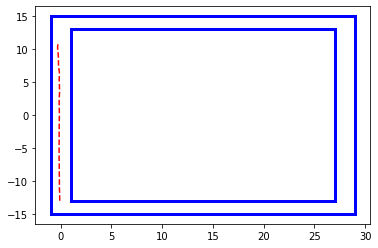

In [65]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

# PARTICLE FILTER PARAMETERS 
# initialize particles
num_particles = 50

# initial noise parameters
initial_x_noise = 0.3
initial_y_noise = 0.3
initial_theta_noise = 0.1

# dynamics noise parameters
x_dynamics_noise = 0.05
y_dynamics_noise = 0.05
v_dynamics_noise = 0.01
theta_dynamics_noise = 0.01

observation = w_true.reset()

# initialize data holders
allX = []
allY = []
allTheta = []
allLidar = []
allV = []
allTimes = []
allParticles = []

# create particles
particle_list = []
for i in range(num_particles):

    init_x = car_dist_s + initial_x_noise * (2 * np.random.random() - 1)
    init_y = car_dist_f + initial_x_noise * (2 * np.random.random() - 1)
    init_theta = car_heading + initial_theta_noise * (2 * np.random.random() - 1)

    w = World(hallWidths, hallLengths, turns,\
              init_x, init_y, init_theta, car_V,\
              episode_length, time_step, lidar_field_of_view,\
              lidar_num_rays, lidar_noise, missing_lidar_rays)

    particle_list.append(w)

allParticles.append(particle_list)

# your code goes here and in the loop below
pos_reference = 1
placeholder_err = 0
placeholder_int_err = 0
placeholder_d_err = 0

delta = pid_control(placeholder_err, placeholder_int_err, placeholder_d_err)

for e in range(episode_length):

    observation, reward, done, info = w_true.step(delta, throttle)

    # compute particle weights
    
    scans = []
    for particle in particle_list:
        scans.append(particle.scan_lidar())
    means = [np.average(x, axis=0) for x in np.transpose(scans)]
    std = [np.std(x, axis=0) for x in np.transpose(scans)]
    dists = []
    for i in range(len(scans[0])):
        dists.append(scipy.stats.norm(loc=means[i], scale=std[i]))
    weights = []
    for particle in particle_list:
        scan = particle.scan_lidar()
        weight = 0.000001
        for i in range(len(scan)):
            prob = float(dists[i].pdf(scan[i]).item())
            if not math.isnan(prob):
                weight += prob
        if not math.isnan(weight):
            weights.append(weight/len(scan))
        else:
            weights.append(0.000001)
    
    # normalize weights
    weights = [(w / sum(weights)) for w in weights]

    # resample particles
    new_particle_list = []
    indices = [i for i, _ in enumerate(weights)]
    for i in indices:
        selected_index = np.random.choice(indices, p=weights)
        particle = particle_list[selected_index]
        new_particle_list.append(particle)
    particle_list = new_particle_list

    # compute state estimates and errors for the pid controller
    avg_observation = 0
    for i in range(len(particle_list)):
        avg_observation += weights[i] * particle_list[i].car_dist_s
    avg_observation /= sum(weights)
    #print(avg_observation, observation[0], avg_observation - observation[0])

    placeholder_err = pos_reference - avg_observation
    if e != 0:
        placeholder_int_err = ((placeholder_err ** 2)/2 - (previous_error ** 2)/2 )/ time_step
        placeholder_d_err = -(placeholder_err - previous_error) / time_step

    delta = pid_control(placeholder_err, placeholder_int_err, placeholder_d_err) 

    previous_error = placeholder_err

    # progress particles  
    for particle in particle_list:
        particle.step(delta, throttle)

    new_particle_list = []
    for particle in particle_list:
        dynamic_x = particle.car_dist_s + x_dynamics_noise * (2 * np.random.random() - 1)
        dynamic_y = particle.car_dist_f + y_dynamics_noise * (2 * np.random.random() - 1)
        dynamic_theta = particle.car_heading + theta_dynamics_noise * (2 * np.random.random() - 1)

        w = World(hallWidths, hallLengths, turns,\
              dynamic_x, dynamic_y, dynamic_theta, car_V,\
              episode_length, time_step, lidar_field_of_view,\
              lidar_num_rays, lidar_noise, missing_lidar_rays)

        new_particle_list.append(w)

    particle_list = new_particle_list

    # break if done
    if done:        
        if e < episode_length - 1:
          print('Unsafe!')
          break

# plot trajectories
fig = plt.figure()
w_true.plotHalls()

# true trajectory 
plt.plot(w_true.allX, w_true.allY, 'r--')

# estimated trajectory
plt.plot(allX, allY, 'g--')